In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '20'

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import time

## Loading dataset

In [68]:
def get_year_from_title(title):
    years = re.findall(r'(\d{4})', title)
    if len(years) > 0:
        year = int(years[-1])
    else: year = 0
    return year

movies_df = pd.read_csv('./temp/ml-latest-small/movies.csv')
movies_df['genres'] = movies_df['genres'].map(lambda x: x.split('|'))
movies_df['year'] = movies_df['title'].map(get_year_from_title)
movies_df = movies_df.explode('genres')
movies_df = pd.get_dummies(data=movies_df, prefix='', prefix_sep='', columns=['genres'], drop_first=True)
movies_df = movies_df.groupby(by=['movieId', 'title', 'year']).sum()
movies_df = movies_df.sort_index()
movies_df = movies_df.reset_index()
movies_df = movies_df.set_index('movieId')
movies_df['intercept'] = 1
movies_df.head()

,title,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,intercept
movieId,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Jumanji (1995),1995,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Grumpier Old Men (1995),1995,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,Waiting to Exhale (1995),1995,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,1
5,Father of the Bride Part II (1995),1995,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [80]:
users_df = pd.read_csv('./temp/ml-latest-small/ratings.csv')
users_df = users_df.drop('timestamp', axis=1)

# maybe average rating is a good feature to find out whether a user will like this movie or not
average_rating = users_df.drop('userId', axis=1).groupby('movieId').mean()
# maybe rating counts for this movie is a goood feature to find out whether a user will like this movie or not
rating_count = users_df.drop('userId', axis=1).groupby(['movieId']).count()

# add to movies_df
movies_df['avg_rating'] = average_rating
movies_df['cnt_rating'] = rating_count
movies_df.fillna(0, inplace=True)

users_df = users_df.set_index('movieId')
users_df.head(100)

,userId,rating
movieId,,
1,1,4.0
3,1,4.0
6,1,4.0
47,1,5.0
50,1,5.0
...,...,...
1445,1,3.0
1473,1,4.0
1500,1,4.0


### Create Movie/User rating dataset

In [81]:
movie_rating_df = users_df.join(movies_df, on='movieId')
# save the titles mapping, movieId to title, for evaluation
titles = movie_rating_df['title']
movie_rating_df = movie_rating_df.drop('title', axis=1)

movie_rating_df = movie_rating_df.drop_duplicates()
movie_rating_df

,userId,rating,year,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,intercept,avg_rating,cnt_rating
movieId,,,,,,,,,,,,,,,,,,,,,
1,1,4.0,1995,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,1,3.920930,215.0
3,1,4.0,1995,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,3.259615,52.0
6,1,4.0,1995,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,3.946078,102.0
47,1,5.0,1995,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,3.975369,203.0
50,1,5.0,1995,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,1,4.237745,204.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166534,610,4.0,2017,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,3.333333,6.0
168248,610,5.0,2017,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,4.142857,7.0
168250,610,5.0,2017,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,3.633333,15.0


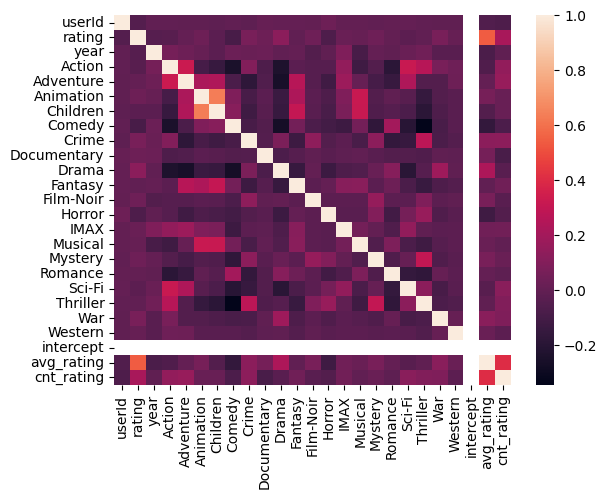

In [82]:
sns.heatmap(movie_rating_df.corr());

### Getting data ready

In [84]:
from sklearn.model_selection import train_test_split

movie_features = movie_rating_df.drop(['userId', 'rating'], axis=1).values.astype('float32')
users = movie_rating_df['userId'].values
users = keras.utils.to_categorical(users).astype('float32')
Y = movie_rating_df['rating'].values.astype('float32')

# normalize the data
mu_movie = np.mean(movie_features, axis=0)
sigma_movie = np.std(movie_features, axis=0)
movie_features = (movie_features - mu_movie) / (sigma_movie + 1e-12)


# split the data into training set and validation set
training_movies, test_movies, training_users, test_users, training_ratings, test_ratings = train_test_split(movie_features,
                                                                                                            users, 
                                                                                                            Y,
                                                                                                            test_size=0.2, shuffle=True)
print(f'Training movies has the shape', training_movies.shape)
print(f'Training users has the shape', training_users.shape)
print(f'Training ratings has the shape', training_ratings.shape)
print()
print(f'Test movies has the shape', test_movies.shape)
print(f'Test users has the shape', test_users.shape)
print(f'Test ratings has the shape', test_ratings.shape)

Training movies has the shape (80544, 23)
Training users has the shape (80544, 611)
Training ratings has the shape (80544,)

Test movies has the shape (20137, 23)
Test users has the shape (20137, 611)
Test ratings has the shape (20137,)


### Create the pipeline

In [85]:
BATCH_SIZE = 512
BUFFER = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((training_movies, training_users, training_ratings))
train_ds = train_ds.shuffle(BUFFER)
train_ds = train_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_movies, test_users, test_ratings))
test_ds = test_ds.batch(BATCH_SIZE, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [86]:
for movie, user, rate in train_ds.take(1):
    print(movie)
    print(np.argmax(user, axis=-1))
    print(rate)

tf.Tensor(
[[ 0.06423113 -0.66121995 -0.56186825 ...  0.         -1.1692275
  -0.38475364]
 [-0.3408354   1.512356   -0.56186825 ...  0.          0.70049953
   1.1643097 ]
 [-0.8809241  -0.66121995  1.7797768  ...  0.          1.7701858
  -0.93338025]
 ...
 [-0.0370355   1.512356    1.7797768  ...  0.         -2.664274
  -0.6106587 ]
 [-1.0159463  -0.66121995  1.7797768  ...  0.          0.5876631
  -0.9011081 ]
 [-0.17205767 -0.66121995 -0.56186825 ...  0.         -1.333936
  -0.88497204]], shape=(512, 23), dtype=float32)
[380  64 105  68 364 414 167 376 457 606 364 107 227 489 100 292  18  89
 139 187  29  91 573 559 401 553 217 418 387 474 541  58  73 357  81 448
 305 559 361  45  57 210 357 103  68 407 432 365 132 247 182 160 182  28
  28 587 140 474 368 432 525 480 533  93 113 414 599 129 371 357 274 229
 428 308 477 605  21 140 177 554 274  19 380 542 560  24 240 560 222 226
  43  48 486 474 474 121 387 120 243 298 140  23 256 177 599  18  23  45
 557 538 309 482 362 113 395  31 

## Define the model

In [87]:
from keras.layers import Dense, Activation, Dropout, Input, Dot
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError, Metric
from keras.models import Model

Each user has a parameter called $\theta$. For example user 1 might have $\theta^{(1)} = \begin{bmatrix}0\\5\\3\end{bmatrix}$ (Imagine we have only 3 categories) that case a movie with categories $\begin{bmatrix}1\\0\\1\end{bmatrix}$ is expected to get the rating as below:
$$
\begin{equation*}
    \text{rating} = \begin{bmatrix}0\\5\\3\end{bmatrix}^\top \cdot \begin{bmatrix}1\\0\\1\end{bmatrix} = 3
\end{equation*}
$$

In [88]:
class ContentBasedRecommender(Model):
    def __init__(self, units, features, num_users, dropout_rate=0.2):
        super(ContentBasedRecommender, self).__init__()
        self.features = features
        self.num_users = num_users
        self.units = units
        self.dropout_rate = dropout_rate

        self.user_dense1 = Dense(units=units // 4, activation='relu')
        self.user_dense2 = Dense(units=units // 2, activation='relu')
        self.user2vec = Dense(units=units, name='user2vec')

        self.movie_dense1 = Dense(units=units // 4, activation='relu')
        self.movie_dense2 = Dense(units=units // 2, activation='relu')
        self.movie2vec = Dense(units=units, name='movie2vec')
        self.dot = Dot(axes=1, name='dot')

        self.dropout = Dropout(dropout_rate)

        self.build(features, num_users)

    def build(self, features, num_users):
        movie = Input(shape=(features,))
        user = Input(shape=(num_users,))
        self.call(movie, user)
        self.built = True

    def call(self, movie, user, training=False):
        # movie has the shape [B, features] 
        # user has the shape [B, num_users]

        # user2vec mapps each user to feature_dimensional space: [B, features]
        user = self.user_dense1(user)
        user = self.dropout(user, training=training)
        user = self.user_dense2(user)
        user = self.dropout(user, training=training)
        user = self.user2vec(user)

        movie = self.movie_dense1(movie)
        movie = self.dropout(movie, training=training)
        movie = self.movie_dense2(movie)
        movie = self.dropout(movie, training=training)
        movie = self.movie2vec(movie)

        return self.dot([user, movie])

In [89]:
model = ContentBasedRecommender(units=1024, 
                                features=movie_features.shape[-1], 
                                num_users=users.shape[-1], 
                                dropout_rate=0.4)
model.summary()

Model: "content_based_recommender_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               156672    
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 user2vec (Dense)            (None, 1024)              525312    
                                                                 
 dense_6 (Dense)             (None, 256)               6144      
                                                                 
 dense_7 (Dense)             (None, 512)               131584    
                                                                 
 movie2vec (Dense)           (None, 1024)              525312    
                                                                 
 dot (Dot)                   (None, 1) 

In [90]:
loss_func = MeanSquaredError()

In [91]:
def get_scheduler(initial_learning_rate=1e-3, min_learning_rate=1e-5, weight=0.9):
    def func(epoch):
        return max(initial_learning_rate * weight ** (epoch), min_learning_rate)
    return func

In [92]:
train_mae = MeanAbsoluteError(name='train_mae')
validation_mae = MeanAbsoluteError(name='test_mae')
optimizer = Adam()
scheduler = get_scheduler(initial_learning_rate=3e-3, weight=0.95)

## Train

In [93]:
@tf.function
def training_step(movie, user, y_true):
    loss = 0.0
    with tf.GradientTape() as tape:
        y_pred = model(movie, user, training=True)
        loss = loss_func(y_true, y_pred)
        train_mae.update_state(y_true, y_pred)
        
    variables = model.trainable_variables
    grads = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return loss

In [94]:
@tf.function
def validation_step(movie, user, y_true):
    y_pred = model(movie, user, training=False)
    loss = loss_func(y_true, y_pred)
    validation_mae.update_state(y_true, y_pred)
    return loss

In [95]:
EPOCHS = 100
train_mean_losses = []
valid_mean_losses = []
train_maes = []
valid_maes = []

for epoch in range(EPOCHS):
    train_mae.reset_states()
    validation_mae.reset_states()
    mean_train_loss = 0.0
    mean_valid_loss = 0.0
    start = time.time()
    learning_rate = scheduler(epoch)
    optimizer.learning_rate = learning_rate
    print(f'Epoch {epoch + 1:>3}')

    for step, (movie, user, y_true) in enumerate(train_ds):
        loss = training_step(movie, user, y_true)
        
        mae = train_mae.result()
        mean_train_loss = mean_train_loss + (1 / (step + 1)) * (loss - mean_train_loss)
        end = time.time()
        print(f'\r{int(end - start):>3} sec | Step {step:>3}\tLoss: {mean_train_loss:>2.4f}\t MAE: {mae:>2.4f}', end='')
    print()
    train_mean_losses.append(mean_train_loss)
    train_maes.append(mae)

    for step, (movie, user, y_true) in enumerate(test_ds):
        loss = validation_step(movie, user, y_true)

        mae = validation_mae.result()
        mean_valid_loss = mean_valid_loss + (1 / (step + 1)) * (loss - mean_valid_loss)
        end = time.time()
        print(f'\r{int(end - start):>3} sec | Step {step:>3}\tLoss: {mean_valid_loss:>2.4f}\t MAE: {mae:>2.4f}', end='')
    print()
    valid_mean_losses.append(mean_valid_loss)
    valid_maes.append(mae)

history = {'loss':train_mean_losses, 'val_loss':valid_mean_losses, 'mae':train_maes, 'val_mae':valid_maes}

Epoch   1
  2 sec | Step 157	Loss: 1.6418	 MAE: 0.92539
  2 sec | Step  39	Loss: 1.1719	 MAE: 0.9149
Epoch   2
  0 sec | Step 157	Loss: 0.7459	 MAE: 0.6678
  0 sec | Step  39	Loss: 0.7976	 MAE: 0.7203
Epoch   3
  0 sec | Step 157	Loss: 0.7126	 MAE: 0.6506
  0 sec | Step  39	Loss: 0.7575	 MAE: 0.6964
Epoch   4
  0 sec | Step 157	Loss: 0.6923	 MAE: 0.6392
  0 sec | Step  39	Loss: 0.7388	 MAE: 0.6849
Epoch   5
  0 sec | Step 157	Loss: 0.6797	 MAE: 0.6327
  0 sec | Step  39	Loss: 0.7183	 MAE: 0.6713
Epoch   6
  0 sec | Step 157	Loss: 0.6740	 MAE: 0.6309
  0 sec | Step  39	Loss: 0.7030	 MAE: 0.6618
Epoch   7
  0 sec | Step 157	Loss: 0.6699	 MAE: 0.6272
  0 sec | Step  39	Loss: 0.6686	 MAE: 0.6367
Epoch   8
  0 sec | Step 157	Loss: 0.6656	 MAE: 0.6262
  0 sec | Step  39	Loss: 0.6736	 MAE: 0.6404
Epoch   9
  0 sec | Step 157	Loss: 0.6587	 MAE: 0.6207
  0 sec | Step  39	Loss: 0.6747	 MAE: 0.6415
Epoch  10
  0 sec | Step 157	Loss: 0.6532	 MAE: 0.6188
  0 sec | Step  39	Loss: 0.6655	 MAE: 0.6353

## Evaluation

In [101]:
total_movies = (movies_df.drop('title', axis=1).values - mu_movie) / (sigma_movie + 1e-12)
total_movies = total_movies.astype('float32')
user = keras.utils.to_categorical([249] * total_movies.shape[0], num_classes=users.shape[-1])
pred = model(total_movies, user, training=False)
indx_pred = np.argsort(pred, axis=0)[::-1, 0]

for i in range(10):
    print(titles.iloc[indx_pred[i]])
    print(pred[indx_pred[i]][0].numpy())
    print()

¡Three Amigos! (1986)
4.8501625

Up (2009)
4.832383

First Knight (1995)
4.8234367

Yes Man (2008)
4.8109016

Eternal Sunshine of the Spotless Mind (2004)
4.803517

Good Year, A (2006)
4.783336

Lord of the Rings: The Two Towers, The (2002)
4.782673

Sex, Lies, and Videotape (1989)
4.7804036

Godfather, The (1972)
4.7795396

Sophie's Choice (1982)
4.7793026



In [102]:
max_loss = 0
y_pred = model(test_movies, test_users, training=False)
for i in range(100):
    y_hat = y_pred[i][0].numpy()
    y_true = test_ratings[i]
    print(f'Predicted {y_hat:>2.2} and the true rating was {y_true}')
    max_loss = max(max_loss, np.abs(y_hat - y_true))

Predicted 4.0 and the true rating was 4.0
Predicted 3.7 and the true rating was 4.0
Predicted 3.7 and the true rating was 3.0
Predicted 2.3 and the true rating was 2.5
Predicted 4.0 and the true rating was 3.0
Predicted 2.0 and the true rating was 2.0
Predicted 3.5 and the true rating was 4.5
Predicted 3.8 and the true rating was 4.0
Predicted 4.6 and the true rating was 4.0
Predicted 3.4 and the true rating was 4.5
Predicted 3.7 and the true rating was 3.5
Predicted 3.7 and the true rating was 5.0
Predicted 3.8 and the true rating was 3.0
Predicted 3.7 and the true rating was 4.0
Predicted 2.9 and the true rating was 3.0
Predicted 3.2 and the true rating was 3.0
Predicted 3.6 and the true rating was 3.0
Predicted 4.3 and the true rating was 4.0
Predicted 3.5 and the true rating was 4.5
Predicted 2.9 and the true rating was 3.0
Predicted 3.0 and the true rating was 4.0
Predicted 3.2 and the true rating was 3.0
Predicted 3.4 and the true rating was 4.0
Predicted 3.9 and the true rating 

In [103]:
max_loss

3.753828

In [104]:
model.save('./models/content_based_v1.tf')

INFO:tensorflow:Assets written to: ./models/content_based_v1.tf/assets


INFO:tensorflow:Assets written to: ./models/content_based_v1.tf/assets
